# Train Agent on Unity Environment

---

## Start the Environment

Below assumes that one has followed the instruction on the README file such that the Unity environment is ready.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


## Background

The algorithm used is based on [Deep Deterministic Policy Gradients (DDPG)](https://arxiv.org/abs/1509.02971). Specifically, it is a distributed version of the algorithm referred to as D3PG which is mentioned [here](https://openreview.net/forum?id=SyZipzbCb). 

In the aforementioned paper, it is referred to as an "Actor-Critic" method which involves an "Actor" which acts as a policy network and a "Critic" which acts as a value network. The "Actor" chooses an action given a state and the "Critic" informs the "Actor" which action in a given state should have its probability of occurring increased because it leads to a high reward and vice versa.

The hyperparameters are mostly inspired by the first [paper](https://arxiv.org/abs/1509.02971):

|Hyperparameters|Value|
|---|---|
|Replay Buffer size|1e6|
|Batch size|512|
|Discount factor (gamma)|0.99|
|Soft update parameter (tau)|1e-3|
|Actor learning rate|5e-4|
|Critic learning rate|5e-4|
|Weight decay|0|
|Ornstein-Uhlenbeck theta|0.15|
|Ornstein-Uhlenbeck sigma|0.2|
|Number of layers|2|
|Number of units for first hidden layer|400|
|Number of units for second hidden layer|300|

with the exception of the batch size and learning rates which were obtained through hyperparameter search.

Batch sizes of 64, 128, 256, 512, and 1024 were tested and 512 performed the best.

Learning rates of 1e-2, 5e-3, 1e-3, 5e-4, 1e-4 and 1e-5 were tested for both the "Actor" and "Critic" networks and 5e-4 performed the best.

Lastly, weight decay of 1e-2 as used in the first paper significantly slowed down learning, and thus the weight decay was set to 0.

The network architecture for both the "Actor" and "Critic" is based on the one from the first paper. It consists of two hidden fully-connected layers with 400 and 300 units, respectively. The action is used as an input to the second hidden layer of the "Critic". The tanh activation function is used for the output layer of the "Actor" to bound the value between -1 and 1. ReLU  is used in all other hidden layers. Lastly, batch normalization is applied to the state input and all layers in "Actor" and all layers prior to the action input in "Critic" such that it has a norm of 1.

Ornstein-Uhlenbeck process is used to help with temporally correlated exploration. The implementation is borrowed from Udacity's [implementation](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py). However, during experimentation, it was discovered that the use of random number from a uniform distribution `random.random()` was harmful to learning. The use of random number from a normal distribution, on the other hand, allowed for fast learning convergence.

## Initialization

Initialize the agent.

In [5]:
from d3pg import Controller

seed = 69

# initialize the algorithm controller
controller = Controller(state_size, action_size, seed)

Define the training function.

In [6]:
import time
from collections import deque
import torch

def train_agent(env, 
                brain_name, 
                n_episodes=1000, 
                n_timesteps=1000, 
                print_every_n_episode=5,
                learn_every_n_timestep=20,
                n_learning=10,
                passing_score=30, 
                actor_model_path="actor.pt",
                critic_model_path="critic.pt"):
    
    # initialize start time
    start_time = time.time()
    
    # initialize score trackers
    scores = []
    scores_deque = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        
        # initialize agent scores (one for each agent)
        agent_scores = np.zeros(num_agents)
        
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # reset the controller
        controller.reset()

        # get the current states (one for each agent)
        states = env_info.vector_observations
        
        for timestep in range(n_timesteps):
            # select actions (one for each agent)
            actions = controller.act(states)
                
            # send actions to the environment
            env_info = env.step(actions)[brain_name]
            
            # get next states
            next_states = env_info.vector_observations
            
            # get rewards
            rewards = env_info.rewards
            
            # get indicators if any episode finishes
            dones = env_info.local_done
            
            # save experiences collected by agents
            controller.save_experience(states, actions, rewards, next_states, dones)
                
            # learn m times every n timestep
            if (timestep + 1) % learn_every_n_timestep == 0:
                controller.learn(n_learning)
            
            # accumulate rewards for each agent
            agent_scores += rewards
            
            # roll over to the next states
            states = next_states
            
            # exit loop if any of the episodes finishes
            if np.any(dones):
                break
        
        # average scores over agents and add it to the score lists
        average_score_over_agents = np.mean(agent_scores)
        scores.append(average_score_over_agents)
        scores_deque.append(average_score_over_agents)
        average_score_over_100_episodes = np.mean(scores_deque)
        
        # print results
        print("\rEpisode {:4d}/{} \t Current score: {:2.4f} | Avg score over 100 episodes: {:2.4f}".format(i_episode, n_episodes, average_score_over_agents, average_score_over_100_episodes), end="")
        
        if i_episode % print_every_n_episode == 0:
            print("\rEpisode {:4d}/{} \t Current score: {:2.4f} | Avg score over 100 episodes: {:2.4f}".format(i_episode, n_episodes, average_score_over_agents, average_score_over_100_episodes))
            
            minutes, seconds = utils.get_minutes_and_seconds_from_start_time(start_time)
            print("Elapsed time: {:3d} minutes {:2d} seconds\n".format(minutes, seconds))
        
        if average_score_over_100_episodes >= passing_score:
            print("\rThe environment is solved in {} episodes with an average score of {:2.4f} over 100 episodes".format(i_episode, average_score_over_100_episodes))
            
            minutes, seconds = utils.get_minutes_and_seconds_from_start_time(start_time)
            print("Elapsed time: {:3d} minutes {:2d} seconds".format(minutes, seconds))
        
            # save models
            torch.save(controller.actor_local.state_dict(), actor_model_path)
            torch.save(controller.critic_local.state_dict(), critic_model_path)
            
            break
    
    return scores

## Training

In [7]:
import utils
from workspace_utils import active_session

In [8]:
with active_session():
    scores = train_agent(env, brain_name)

Episode    5/1000 	 Current score: 0.8735 | Avg score over 100 episodes: 0.9025
Elapsed time:   1 minutes 30 seconds

Episode   10/1000 	 Current score: 1.4755 | Avg score over 100 episodes: 1.0431
Elapsed time:   3 minutes  5 seconds

Episode   15/1000 	 Current score: 2.6620 | Avg score over 100 episodes: 1.5084
Elapsed time:   4 minutes 46 seconds

Episode   20/1000 	 Current score: 6.5305 | Avg score over 100 episodes: 2.4667
Elapsed time:   6 minutes 38 seconds

Episode   25/1000 	 Current score: 19.4920 | Avg score over 100 episodes: 5.1008
Elapsed time:   8 minutes 40 seconds

Episode   30/1000 	 Current score: 29.2980 | Avg score over 100 episodes: 8.8444
Elapsed time:  10 minutes 56 seconds

Episode   35/1000 	 Current score: 35.1355 | Avg score over 100 episodes: 12.5051
Elapsed time:  13 minutes 24 seconds

Episode   40/1000 	 Current score: 38.0010 | Avg score over 100 episodes: 15.5925
Elapsed time:  16 minutes  5 seconds

Episode   45/1000 	 Current score: 38.4430 | Avg s

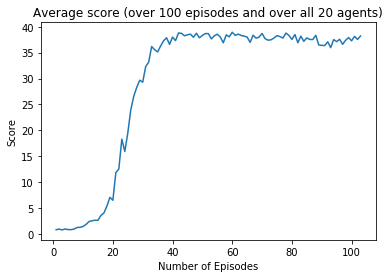

In [9]:
utils.plot_scores(scores, "Average score (over 100 episodes and over all 20 agents)")

## Future Work

The [distributional version](https://openreview.net/forum?id=SyZipzbCb) of the algorithm used is the logical next step to improve the performance. The linked paper uses a categorical distribution with 51 atoms. According to the paper, the use of distributional "Critic" update leads to an improvement over the non-distributional version of the algorithm.